<div style="border-radius:10px;border:#B7B7A4 solid;padding:15px;background-color:#2874A6;font-size:110%;text-align:left">
<a id=toc></a>
<h1 style="padding: 35px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-size: 100% auto;background-position: 0px 0px; 
"><span style='color:white'><b>ML Model Transparency: LIME for Explainability in Python</b></span></h1>


# **Introduction**
### Machine learning is a crucial tool in today’s business landscape, enabling companies to tackle complex challenges. With the exponential growth of data volume and intricate use cases, data scientists are increasingly using sophisticated models for analysis and predictions. However, the balance between model accuracy and ease of interpretation remains a challenge. Advanced techniques like Bagging, Boosting, and Random Forests are often used for high accuracy but lack transparency, making it difficult for stakeholders to understand their inner workings. Simpler models like Linear Regression or Decision Trees offer greater interpretability but may sacrifice accuracy. This dilemma highlights the need for trust in machine learning models for widespread adoption across industries. This blog explores balancing accuracy and understandability in machine learning models, aiming to make them more accessible for everyone.

# Load the libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

# **Data loading**

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')


print(f'Shape of train data: {df_train.shape}')
print(f'Shape of test data: {df_test.shape}')


SEED = 12
n_trials = 2
target = 'Exited'

df_train = df_train.drop(['id', 'Surname'], axis = 1)
df_test = df_test.drop(['id', 'Surname'], axis = 1)


features = df_train.columns.drop(target)
CAT_FEATS = df_train.select_dtypes(include='object').columns
NUM_FEATS = [x for x in df_train.columns if x not in CAT_FEATS and x != target and x in features]

assert target not in features
assert target not in CAT_FEATS
assert target not in NUM_FEATS


# Encode all the categorical features
df_train_cat_encode = df_train[CAT_FEATS]
df_test_cat_encode= df_test[CAT_FEATS]

# Dummify the train and test data
df_train_cat_encoded = pd.get_dummies(df_train_cat_encode, columns = CAT_FEATS, drop_first=True)
df_test_cat_encoded = pd.get_dummies(df_test_cat_encode, columns = CAT_FEATS, drop_first=True)


# Scale all the numerical features
df_train_num_scale = df_train[NUM_FEATS]
df_test_num_scale = df_test[NUM_FEATS]

from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
minmax_scaler = MinMaxScaler()

# Fit the scaler on the training data
minmax_scaler.fit(df_train_num_scale)

# Scale the training data
df_train_num_scaled = minmax_scaler.transform(df_train_num_scale)
df_train_num_scaled = pd.DataFrame(df_train_num_scaled, columns=df_train_num_scale.columns)

# Scale the test data using the parameters from the training data
df_test_num_scaled = minmax_scaler.transform(df_test_num_scale)
df_test_num_scaled = pd.DataFrame(df_test_num_scaled, columns=df_test_num_scale.columns)


# Concatenate datasets
df_train_combined = pd.concat([df_train_cat_encoded.reset_index(drop=True), df_train_num_scaled.reset_index(drop=True)], axis=1)

# Concatenate test datasets
df_test_combined = pd.concat([df_test_cat_encoded.reset_index(drop=True), df_test_num_scaled.reset_index(drop=True)], axis=1)


df_train_combined['Exited'] = df_train['Exited']

df_train_combined = df_train_combined.head(500)


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df_train_combined.drop(columns=[target])
y = df_train_combined[target]

Shape of train data: (165034, 14)
Shape of test data: (110023, 13)


# **The building block of modeling**

## Decision Tree Model

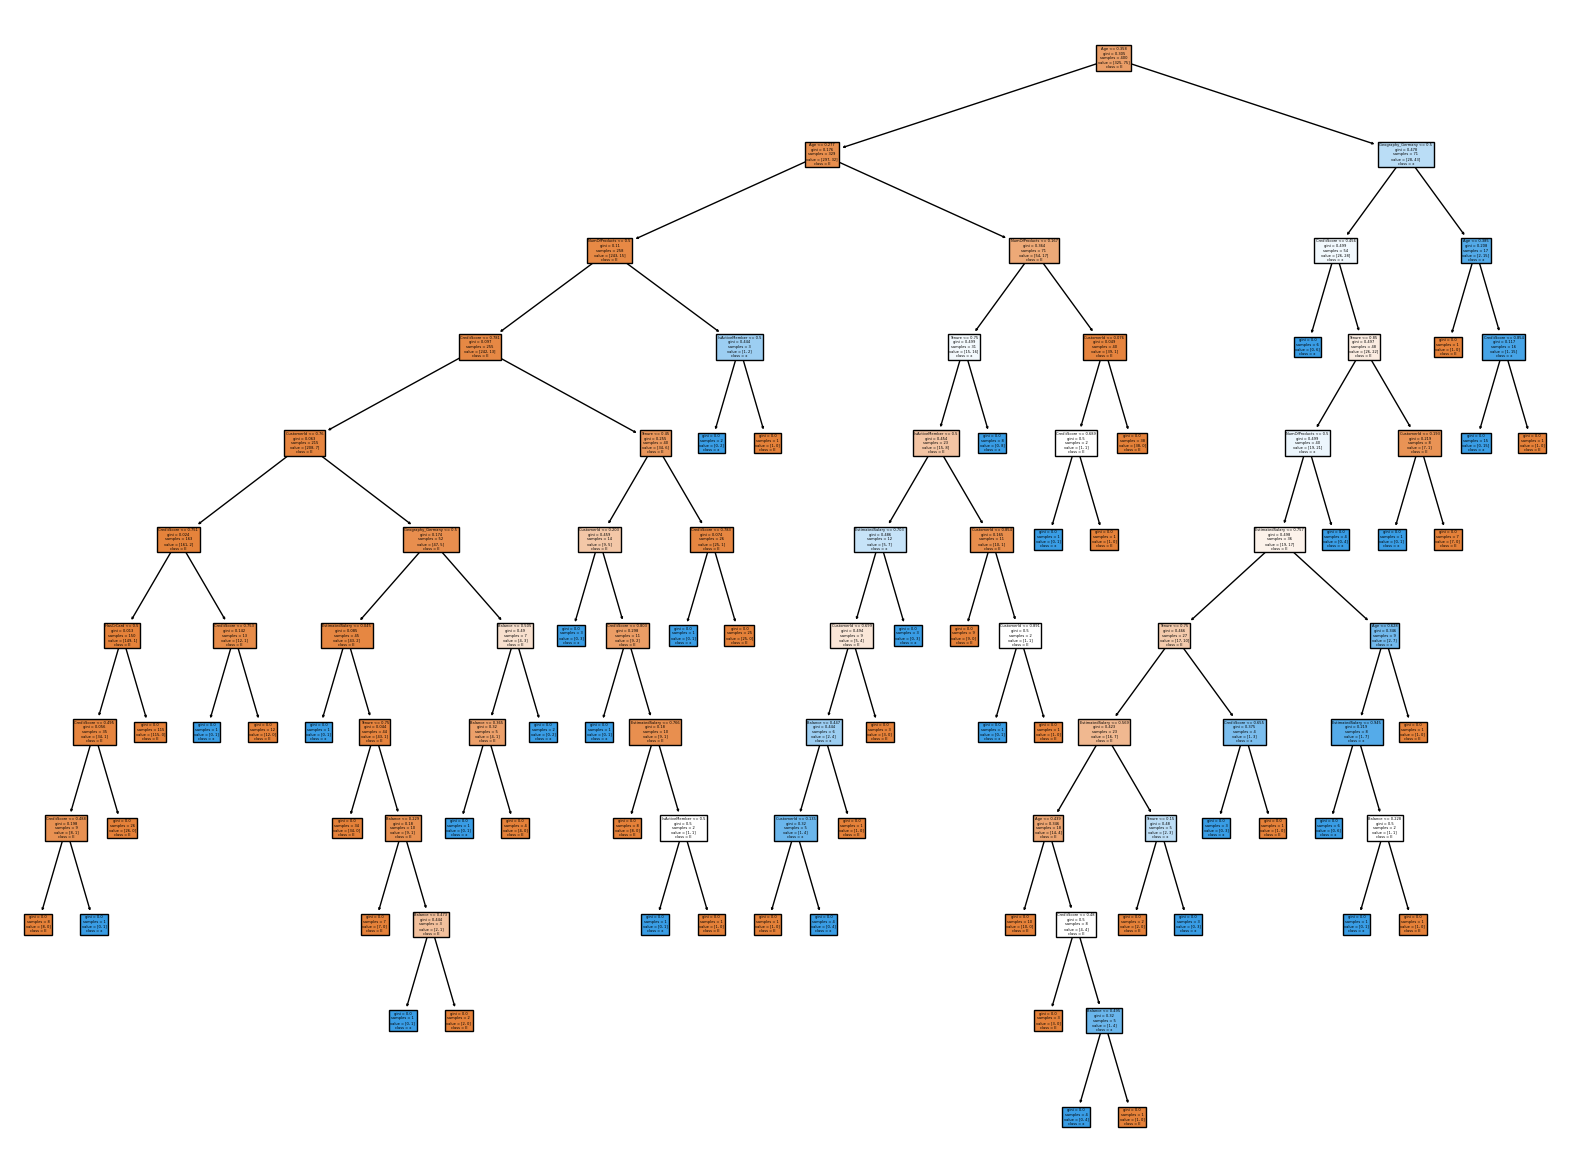

Training Accuracy: 1.0
Test Accuracy: 0.72


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a Decision Tree classifier
clf_DecisionTree = DecisionTreeClassifier(random_state=42)
clf_DecisionTree.fit(X_train, y_train)

# Visualize the Decision Tree
plt.figure(figsize=(20, 15))
plot_tree(clf_DecisionTree, filled=True, feature_names= df_train_combined.columns.drop(target), class_names=target)
plt.savefig("DT.png")
plt.show()

# Evaluate the model
y_pred_train = clf_DecisionTree.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

y_pred_test = clf_DecisionTree.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)


## Logistic Regression Model

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a Logistic Regression model with increased max_iter
clf_LogisticRegression = LogisticRegression(max_iter=1000, random_state=42)
clf_LogisticRegression.fit(X_train, y_train)

# Evaluate the model
train_accuracy = clf_LogisticRegression.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

test_accuracy = clf_LogisticRegression.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


# Predict probabilities and class for any given record (in this case, the first record in the test set)
record_index = 1
predicted_probabilities = clf_LogisticRegression.predict_proba(X_test.iloc[[record_index]])
predicted_class = clf_LogisticRegression.predict(X_test.iloc[[record_index]])
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
print("Predicted Probabilities for Record {}: {}".format(record_index, predicted_probabilities))
print("Predicted Class for Record {}: {}".format(record_index, predicted_class))

# Obtain the intercept and coefficients from the trained Logistic Regression model
intercept = clf_LogisticRegression.intercept_[0]
coefficients = clf_LogisticRegression.coef_[0]

# Write the equation
equation = f"P(y=1 | X) = 1 / (1 + e^(-({intercept:.4f} {' + ' if intercept > 0 else ''} {' + '.join([f'({coef:.4f} * {feat})' for coef, feat in zip(coefficients, X.columns)])})))"

print("Logistic Regression Equation:")
print(equation)

Training Accuracy: 0.85
Test Accuracy: 0.83
Predicted Probabilities for Record 1: [[0.95404717 0.04595283]]
Predicted Class for Record 1: [0]
Logistic Regression Equation:
P(y=1 | X) = 1 / (1 + e^(-(-2.3000  (1.3355 * Geography_Germany) + (0.3696 * Geography_Spain) + (-0.7362 * Gender_Male) + (-0.2597 * CustomerId) + (0.3967 * CreditScore) + (4.3726 * Age) + (-0.3758 * Tenure) + (0.2839 * Balance) + (-0.6963 * NumOfProducts) + (-0.0033 * HasCrCard) + (-1.2023 * IsActiveMember) + (0.4897 * EstimatedSalary))))


In [7]:
for i in range(20):
    predicted_probabilities = clf_LogisticRegression.predict_proba(X_test.iloc[[i]])
    predicted_class = clf_LogisticRegression.predict(X_test.iloc[[i]])
    print(f'Record: {i} | Probability: {predicted_probabilities} | Predicted Class: {predicted_class}')

Record: 0 | Probability: [[0.82013921 0.17986079]] | Predicted Class: [0]
Record: 1 | Probability: [[0.95404717 0.04595283]] | Predicted Class: [0]
Record: 2 | Probability: [[0.79752827 0.20247173]] | Predicted Class: [0]
Record: 3 | Probability: [[0.50857845 0.49142155]] | Predicted Class: [0]
Record: 4 | Probability: [[0.7240509 0.2759491]] | Predicted Class: [0]
Record: 5 | Probability: [[0.81866141 0.18133859]] | Predicted Class: [0]
Record: 6 | Probability: [[0.65059695 0.34940305]] | Predicted Class: [0]
Record: 7 | Probability: [[0.71245036 0.28754964]] | Predicted Class: [0]
Record: 8 | Probability: [[0.96170425 0.03829575]] | Predicted Class: [0]
Record: 9 | Probability: [[0.65776099 0.34223901]] | Predicted Class: [0]
Record: 10 | Probability: [[0.7481273 0.2518727]] | Predicted Class: [0]
Record: 11 | Probability: [[0.88804875 0.11195125]] | Predicted Class: [0]
Record: 12 | Probability: [[0.85959817 0.14040183]] | Predicted Class: [0]
Record: 13 | Probability: [[0.67627124 

# **So what is the challenge?**
### As data complexity grows, basic models like logistic regression and decision trees may struggle. To address this, data scientists turn to more complex models like Random Forest, LightGBM, or XGBoost. However, these models are harder to explain — they’re like black boxes. Businesses may hesitate to adopt them because they can’t easily understand why a specific prediction is made. While these models offer superior performance, their opacity can be a drawback. It’s a trade-off between accuracy and interoperability and as data science evolves, striking a balance between model complexity and explainability remains a key challenge. In this next section let’s build a boosting model (Random forest) to understand this better.

# **Need for model explainability**

## Random forest model

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a Logistic Regression model with increased max_iter
clf_RFC = RandomForestClassifier(random_state=42)
clf_RFC.fit(X_train, y_train)

# Evaluate the model
train_accuracy = clf_RFC.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

test_accuracy = clf_RFC.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 1.0
Test Accuracy: 0.85


# **What is LIME?**
### LIME, or Local Interpretable Model-agnostic Explanations, is a machine learning tool that enhances model interpretability by training local surrogate models to explain individual predictions. It differs from traditional methods that analyze black box models’ internal components. LIME perturbs input data samples and observes changes in predictions, providing insights into model behavior. It is model-agnostic, allowing it to be applied to any machine learning model, making it versatile for explaining predictions across various domains and applications.

# **Application of LIME**

## Iteration 1

Random Forest Predicted Probabilities for Record: 38 and probabilities are : [[0.77 0.23]] and predicted class is : [0]


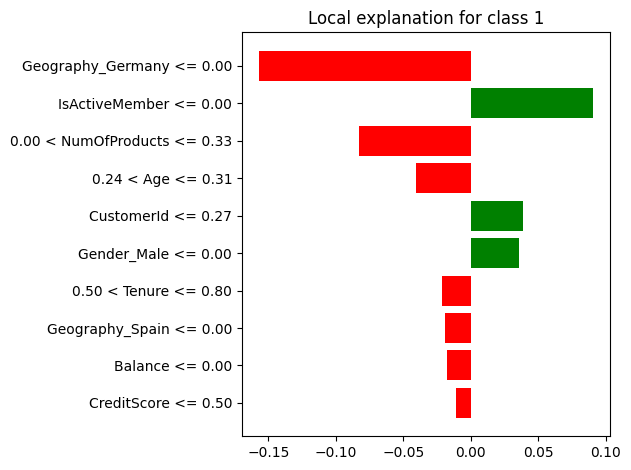

In [13]:
# Predict probabilities and class for any given record (in this case, the first record in the test set)
record_index = 38
predicted_probabilities_rf = clf_RFC.predict_proba(X_test.iloc[[record_index]])
predicted_class_rf = clf_RFC.predict(X_test.iloc[[record_index]])
print(f'Random Forest Predicted Probabilities for Record: {record_index} and probabilities are : {predicted_probabilities_rf} and predicted class is : {predicted_class_rf}')


from lime.lime_tabular import LimeTabularExplainer

# Initialize the LimeTabularExplainer with valid feature names
explainer = LimeTabularExplainer(X_train.values, 
                                 feature_names=X_train.columns.tolist(), 
                                 class_names=df_train[target].unique(), 
                                 mode='classification')

# Explain the prediction of the Random Forest model for the chosen instance
exp = explainer.explain_instance(X_test.iloc[[record_index]].values[0], clf_RFC.predict_proba, num_features = 10)

# Visualize the explanation
exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

## **How to interpret this result:**

* For record #38, the random forest model classified it as 0 and the predicted probabilities were [0.84, 0.16]
* The bar chart shows that Red bars influence the prediction of 0 (Malignant)

## Iteration 2

Random Forest Predicted Probabilities for Record: 23 and probabilities are : [[0.24 0.76]] and predicted class is : [1]


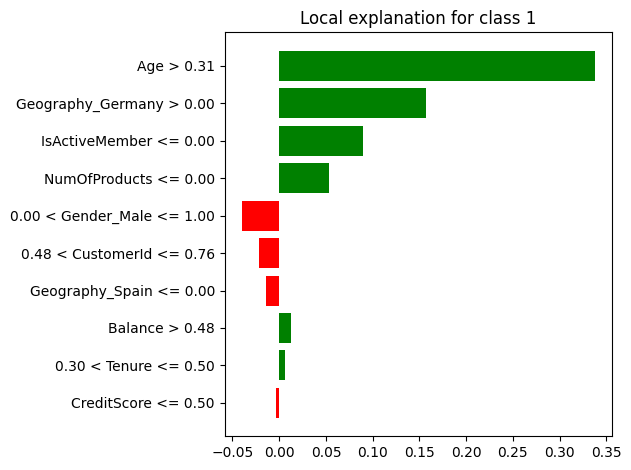

In [14]:
# Predict probabilities and class for any given record (in this case, the first record in the test set)
record_index = 23
predicted_probabilities_rf = clf_RFC.predict_proba(X_test.iloc[[record_index]])
predicted_class_rf = clf_RFC.predict(X_test.iloc[[record_index]])
print(f'Random Forest Predicted Probabilities for Record: {record_index} and probabilities are : {predicted_probabilities_rf} and predicted class is : {predicted_class_rf}')


from lime.lime_tabular import LimeTabularExplainer

# Initialize the LimeTabularExplainer with valid feature names
explainer = LimeTabularExplainer(X_train.values, 
                                 feature_names=X_train.columns.tolist(), 
                                 class_names=df_train[target].unique(), 
                                 mode='classification')

# Explain the prediction of the Random Forest model for the chosen instance
exp = explainer.explain_instance(X_test.iloc[[record_index]].values[0], clf_RFC.predict_proba, num_features = 10)

# Visualize the explanation
exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

## How to interpret this result:

* For record #23, the random forest model classified it as 1 (Benign) and the predicted probabilities were [0.24, 0.76]
* The bar chart shows that Green bars influence the prediction of 1(Benign)

# Conclusion
### In summary, achieving a balance between the accuracy and explainability of machine learning models is vital. This not only fosters trust among stakeholders but also boosts the confidence of data science teams in the model’s performance, as they can justify its predictions. Tools like LIME play a crucial role by providing clear and easy explanations that are essential for driving innovation and solving complex problems.